In this code example, we'll compute the control forces required for a 3D quadrotor to follow a trajectory.

In [1]:
%pylab inline
from pylab import *

import control
import mpl_toolkits.mplot3d
import scipy.integrate

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../lib")

import flashlight.curve_utils           as curve_utils
import flashlight.interpolate_utils     as interpolate_utils
import flashlight.ipython_display_utils as ipython_display_utils
import flashlight.quadrotor_3d          as quadrotor_3d
import flashlight.spline_utils          as spline_utils

Populating the interactive namespace from numpy and matplotlib
Initializing flashlight v0.0.1
flashlight.quadrotor_3d: Constructing sympy symbols...
flashlight.quadrotor_3d: Finished constructing sympy symbols (0.009 seconds).
flashlight.quadrotor_3d: Loading sympy modules...
flashlight.quadrotor_3d: Finished loading sympy modules (0.005 seconds).


/Users/mike/Code/GitHub/flashlight/code/lib/flashlight/transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


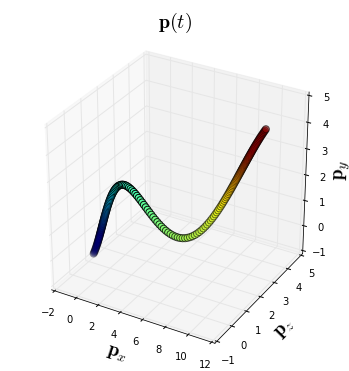

In [2]:
T_z = matrix([0,1,2,3]).T.A
T_y = matrix([0,1,2,3]).T.A
T_x = matrix([0,1,2,3]).T.A
T   = c_[T_z, T_y, T_x]
P_z = matrix([0,0,1,4]).T.A
P_y = matrix([0,3,1,4]).T.A
P_x = matrix([0,3,7,10]).T.A
P   = c_[P_z, P_y, P_x]

num_samples = 200

C, T, sd = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])
    
P_eval, T_eval, dT = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd, num_samples=num_samples)

T_s = matrix([0.0,1.2,1.8,3.0]).T.A
P_s = matrix([0.0,0.3,0.7,1.0]).T.A

C_s, T_s, sd_s = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P_s, T_s, degree=7, lamb=[0,0,0,1,0])
    
P_s_eval, T_s_eval, dT_s = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C_s, T_s, sd_s, num_samples=num_samples)

t = linspace(0.0,10.0,num_samples)
s_spline = P_s_eval

P_eval_spline, t_spline, P_eval_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s_spline)

figsize(6,6);
fig = plt.figure();
ax = fig.add_subplot(111, projection="3d");
ax.scatter(P_eval_spline[:,2], P_eval_spline[:,0], P_eval_spline[:,1], c=t, s=50);
title("$\\mathbf{p}(t)$\n", fontsize=20);
ax.set_zlabel("$\\mathbf{p}_y$", fontsize=20);
xlabel("$\\mathbf{p}_x$", fontsize=20); ylabel("$\\mathbf{p}_z$", fontsize=20);

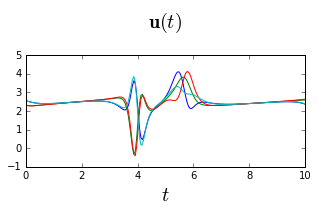

In [3]:
t_begin       = t[0]
t_end         = t[-1]
num_timesteps = num_samples

p   = P_eval_spline
psi = zeros_like(t)
dt  = (t_end-t_begin) / num_timesteps

q_qdot_qdotdot = quadrotor_3d.compute_state_space_trajectory_and_derivatives(p, psi, dt)
u              = quadrotor_3d.compute_control_trajectory(q_qdot_qdotdot)

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]); plot(t, u[:,2]); plot(t, u[:,3]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

In [4]:
x_nominal, q_nominal, qdot_nominal, qdotdot_nominal = \
    quadrotor_3d.pack_state_space_trajectory_and_derivatives(q_qdot_qdotdot)
    
x_0 = x_nominal[0]

def compute_x_dot(x_t, t):

    x_t     = matrix(x_t).T
    u_t     = u_interp_func(clip(t, t_begin, t_end))
    x_dot_t = quadrotor_3d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim = 200
t_sim             = linspace(t_begin, t_end, num_timesteps_sim)
u_interp_func     = interpolate_utils.interp1d_vector_wrt_scalar(t, u, kind="cubic")
x_sim             = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

quadrotor_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, tmp_dir="tmp")

# quadrotor_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, tmp_dir="tmp",
#                   request_delete_tmp_dir=True, verbose=False, savefig=True,
#                   out_dir="data/06", out_file="00.mp4")

ipython_display_utils.get_inline_video("data/06/00.mp4")

/Users/mike/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/traits/has_traits.py:1536: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


In [5]:
m = quadrotor_3d.m
g = quadrotor_3d.g

x_star = matrix([0,0,0,0,0,0,0,0,0,0,0,0]).T
u_star = matrix([m*g/4.0,m*g/4.0,m*g/4.0,m*g/4.0]).T

Q = diag([1,1,1,1,1,1,1,1,1,1,1,1])
R = diag([1,1,1,1])

A, B    = quadrotor_3d.compute_df_dx_and_df_du(x_star, u_star)
K, S, E = control.lqr(A, B, Q, R)

x_disturbance = matrix([0.0, 0.0, 0.0, pi/4.0, 0.0, 0.0, 5.0, 5.0, 5.0, -4.0*pi, 0.0, 0.0]).T
x_0           = (x_star + x_disturbance).A1

def compute_x_dot(x_t, t):

    x_t     = matrix(x_t).T    
    x_bar_t = x_t - x_star
    u_bar_t = -K*x_bar_t
    u_t     = u_bar_t + u_star
    x_dot_t = quadrotor_3d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim = 200
t_sim             = linspace(t_begin, t_end, num_timesteps_sim)
x_sim             = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

quadrotor_3d.draw(t_sim, x_sim, tmp_dir="tmp")

# quadrotor_3d.draw(t_sim, x_sim, tmp_dir="tmp",
#                   request_delete_tmp_dir=True, verbose=False, savefig=True,
#                   out_dir="data/06", out_file="01.mp4")

ipython_display_utils.get_inline_video("data/06/01.mp4")

In [6]:
x_nominal, q_nominal, qdot_nominal, qdotdot_nominal = \
    quadrotor_3d.pack_state_space_trajectory_and_derivatives(q_qdot_qdotdot)

u_nominal = u

x_0 = x_nominal[0]

Q = diag([1,1,1,1,1,1,1,1,1,1,1,1])
R = diag([1,1,1,1])

def compute_x_dot(x_t, t):

    x_t = matrix(x_t).T
    
    x_nominal_t = x_nominal_interp_func(clip(t, t_begin, t_end))
    u_nominal_t = u_nominal_interp_func(clip(t, t_begin, t_end))
    
    A_t, B_t      = quadrotor_3d.compute_df_dx_and_df_du(x_nominal_t, u_nominal_t)
    K_t, S_t, E_t = control.lqr(A_t, B_t, Q, R)
    
    x_bar_t = x_t - x_nominal_t
    u_bar_t = -K_t*x_bar_t
    u_t     = u_bar_t + u_nominal_t
    x_dot_t = quadrotor_3d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim     = 200
t_sim                 = linspace(t_begin, t_end, num_timesteps_sim)
x_nominal_interp_func = interpolate_utils.interp1d_vector_wrt_scalar(t, x_nominal, kind="cubic")
u_nominal_interp_func = interpolate_utils.interp1d_vector_wrt_scalar(t, u_nominal, kind="cubic")
x_sim                 = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

quadrotor_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal)

# quadrotor_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, tmp_dir="tmp",
#                   request_delete_tmp_dir=True, verbose=False, savefig=True,
#                   out_dir="data/06", out_file="02.mp4")

ipython_display_utils.get_inline_video("data/06/02.mp4")

In [7]:
x_disturbance = matrix([0.0, 0.0, 0.0, pi/4.0, 0.0, 0.0, 5.0, 5.0, 5.0, -4.0*pi, 0.0, 0.0]).T
x_0           = (matrix(x_nominal[0]).T + x_disturbance).A1
x_sim         = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

quadrotor_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal)

# quadrotor_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, tmp_dir="tmp",
#                   request_delete_tmp_dir=True, verbose=False, savefig=True,
#                   out_dir="data/06", out_file="03.mp4")

ipython_display_utils.get_inline_video("data/06/03.mp4")